# Ball Tree Nearest Neighbor

This is a work in progress implementation using the BallTree algoritm for the nearest neighbor search.

> **Why use BallTree instead of KDTree?**  
> Because `HaversineDistance64 is not valid for KDTree`


In [1]:
from herbie import Herbie
import herbie
from toolbox import EasyMap, pc, ccrs
from sklearn.neighbors import BallTree
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from pathlib import Path


import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def time_since(t):
    return (pd.Timestamp("now") - t).total_seconds()


def nearest_neighbor(
    ds, points, k=1, tree_from_pickle=True, verbose=False, replant_tree=False
):
    """Find values at nearest neighbor locations.

    TODO: Get nearest neighbor or weighted mean of four nearest.

    Note: KDTree can't be used because it doesn't support the haversine
    minimization metric which is optimal for lat/lon distances, (like
    handeling the (-180,180] and (0,360] longitudes.)

    Parameters
    ----------
    ds : xarray.dataset
        Must include latitude and longitude coordinate.
    points : DataFrame
        A DataFrame with columns 'latitude' and 'longitude'.
    replant_tree : bool
        False will load the pickled BallTree object for the model if
        it exists. If True, then will remake the BallTree and save the
        pickled object.
    k : int
        Number of neighbors.
    """
    # Vector of just grid's lat/lon coordinates and indices
    df_grid = (
        ds[["latitude", "longitude"]]
        .drop(
            [
                coord
                for coord in ds.coords
                if not ("x" in ds[coord].dims or "y" in ds[coord].dims)
            ]
        )
        .to_dataframe()
    )

    # Convert lat/lon to radians for the BallTree
    df_grid_radians = np.deg2rad(df_grid).rename(
        columns={"latitude": "latitude_radians", "longitude": "longitude_radians"}
    )

    # -----------------------------
    # Build or load BallTree object

    # Path to the pickled BallTree objected for the model.
    pkl_BallTree_file = (
        herbie.config["default"]["save_dir"]
        / "BallTree"
        / f"{ds.model}_{ds.x.size}-{ds.y.size}.pkl"
    )
    pkl_BallTree_file.parent.mkdir(parents=True, exist_ok=True)

    if pkl_BallTree_file.exists() and not replant_tree:
        with open(pkl_BallTree_file, "rb") as f:
            tree = pickle.load(f)
    else:
        # Create the BallTree tree
        timer = pd.Timestamp("now")
        tree = BallTree(
            df_grid_radians[["latitude_radians", "longitude_radians"]],
            metric="haversine",
        )
        print(
            f"Created BallTree in {time_since(timer):.2} seconds --> {pkl_BallTree_file}"
        )

        # Save the tree object for faster loading
        with open(pkl_BallTree_file, "wb") as f:
            pickle.dump(tree, f)

    # -------------------------------------
    # Query points to find nearest neighbor
    # The queries lat/lon points need to be in Radians
    # TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
    dist, ind = tree.query(
        np.deg2rad(points[["latitude", "longitude"]]),
        k=k,
    )

    # Dataframe for each value of k
    k_points = []
    for i in range(k):
        _points = points.copy()
        _points["distance_grid"] = (
            dist[:, i] * 6371
        )  # Multiply by radius of the earth (km)
        _points["index_grid"] = ind[:, i]

        _points = pd.concat(
            [
                _points,
                df_grid.reset_index()
                .iloc[_points["index_grid"]]
                .add_suffix("_grid")
                .reset_index(drop=True),
            ],
            axis=1,
        )

        k_points.append(_points)
    k_points[0]

    # TODO: put this in the loop abvoe
    # Get cooresponding values from xarray
    # https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing
    matches = (
        ds[[i for i in ds if ds[i].dims != ()]]
        .sel(x=k_points[0].x_grid.to_xarray(), y=k_points[0].y_grid.to_xarray())
        .to_pandas()
    )
    result = pd.concat(
        [
            k_points[0]
            .drop(
                columns=[
                    "index_grid",
                    "y_grid",
                    "x_grid",
                    "latitude_grid",
                    "longitude_grid",
                ]
            )
            .add_suffix("_point"),
            matches,
        ],
        axis=1,
    )
    return result


H = Herbie("2024-03-16 00:00", model="hrrr", product="sfc", fxx=0)
ds = H.xarray("(?:TMP|DPT):2 m", remove_grib=False)


# ======================================================================
# =======================Sample Data====================================
import random
import string


def generate_random_string(len=8):
    """Generate a random string."""
    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 100
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points["stid"] = [generate_random_string() for _ in range(n)]
# ======================================================================

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [13]:
n = 1000
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points["stid"] = [generate_random_string() for _ in range(n)]

print(f"Testing BallTree for n={n}\tTime=", end="")
timer = pd.Timestamp("now")
a = nearest_neighbor(ds, points)
print(time_since(timer))

len(a)

Testing BallTree for n=1000	Time=0.260104


1000

In [16]:
%%timeit
a = nearest_neighbor(ds, points)

258 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Benchmark

A simple benchmark suggests this is much faster than my current `nearest_points` accessor, especially when points get more than 100.


Testing BallTree for n=1	Time=0.208286 seconds.
Testing Herbie   for n=1	Time=0.572853 seconds.
Testing BallTree for n=51	Time=0.305586 seconds.
Testing Herbie   for n=51	Time=6.595229 seconds.
Testing BallTree for n=101	Time=0.215764 seconds.
Testing Herbie   for n=101	Time=10.581094 seconds.
Testing BallTree for n=151	Time=0.225869 seconds.
Testing Herbie   for n=151	Time=16.177962 seconds.
Testing BallTree for n=201	Time=0.275229 seconds.
Testing BallTree for n=251	Time=0.204317 seconds.
Testing BallTree for n=301	Time=0.285313 seconds.
Testing BallTree for n=351	Time=0.277995 seconds.
Testing BallTree for n=401	Time=0.245202 seconds.
Testing BallTree for n=451	Time=0.22386 seconds.
Testing BallTree for n=501	Time=0.225786 seconds.
Testing BallTree for n=551	Time=0.304995 seconds.
Testing BallTree for n=601	Time=0.232765 seconds.
Testing BallTree for n=651	Time=0.248038 seconds.
Testing BallTree for n=701	Time=0.261224 seconds.
Testing BallTree for n=751	Time=0.252442 seconds.
Testi

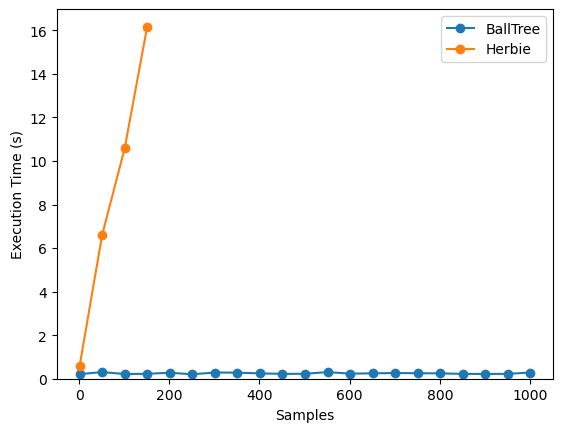

In [4]:
df_grid = ds[["latitude", "longitude"]].to_dataframe().reset_index()

times = []
samples = []
ctrl_times = []
ctrl_samples = []

for n in range(1, 1002, 50):
    points = (
        ds[["latitude", "longitude"]]
        .to_dataframe()[["latitude", "longitude"]]
        .sample(n)
        .reset_index(drop=True)
    )
    points["stid"] = [generate_random_string() for _ in range(n)]

    print(f"Testing BallTree for n={n}\tTime=", end="")
    timer = pd.Timestamp("now")
    a = nearest_neighbor(ds, points)
    times.append(time_since(timer))
    samples.append(n)
    print(times[-1], "seconds.")

    if n < 200:
        print(f"Testing Herbie   for n={n}\tTime=", end="")
        timer = pd.Timestamp("now")
        aa = ds.herbie.nearest_points(points)
        ctrl_times.append(time_since(timer))
        ctrl_samples.append(n)
        print(ctrl_times[-1], "seconds.")


plt.plot(samples, times, marker="o", label="BallTree")
plt.plot(ctrl_samples, ctrl_times, marker="o", label="Herbie")
plt.ylabel("Execution Time (s)")
plt.xlabel("Samples")
plt.ylim(ymin=0)

plt.legend()

# Sample Map


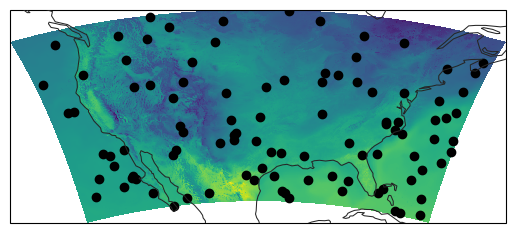

In [5]:
ax = EasyMap().ax

a = nearest_neighbor(ds, df_grid.sample(100)[["latitude", "longitude"]])

ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m)
ax.scatter(a.longitude, a.latitude, color="k")

# Sandbox

1. Create a DataFrame of the grid's lat/lon coordiantes in radians.
1. Create or load BallTree for model-dimensions.
1. Query requested data.


In [2]:
def time_since(t):
    return (pd.Timestamp("now") - t).total_seconds()


# NWP data
H = Herbie("2024-03-16 00:00", model="hrrr", product="sfc", fxx=0)
ds = H.xarray("(?:TMP|DPT):2 m", remove_grib=False)


replant_tree = True

# Vector of just grid's lat/lon coordinates and indices
df_grid = (
    ds[["latitude", "longitude"]]
    .drop(
        [
            coord
            for coord in ds.coords
            if not ("x" in ds[coord].dims or "y" in ds[coord].dims)
        ]
    )
    .to_dataframe()
)

# Convert lat/lon to radians for the BallTree
df_grid_radians = np.deg2rad(df_grid).rename(
    columns={"latitude": "latitude_radians", "longitude": "longitude_radians"}
)

# ======================================================================
# =======================Sample Data====================================
import random
import string


def generate_random_string(len=8):
    """Function to generate a random string."""
    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 500
points = df_grid.sample(n)[["latitude", "longitude"]].reset_index(drop=True)
points["stid"] = [generate_random_string() for _ in range(n)]
# ======================================================================

points

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,latitude,longitude,stid
0,32.227322,281.688677,On6EF5dV
1,35.019744,259.040767,Ip7LQuYz
2,34.481881,273.457950,SNyEUY8z
3,52.059332,253.967308,bQXiJPNf
4,36.647790,278.163984,lbB8CE80
...,...,...,...
495,38.324749,258.606907,xY1hQBMs
496,29.324184,265.337524,L2gDs3zR
497,37.890590,279.442086,JvDQvYOL
498,37.858233,251.947119,fGqTziAW


In [3]:
# -----------------------------
# Build or load BallTree object

# Path to the pickled BallTree objected for the model.
pkl_BallTree_file = (
    herbie.config["default"]["save_dir"]
    / "BallTree"
    / f"{ds.model}_{ds.x.size}-{ds.y.size}.pkl"
)
pkl_BallTree_file.parent.mkdir(parents=True, exist_ok=True)


if pkl_BallTree_file.exists() and not replant_tree:
    with open(pkl_BallTree_file, "rb") as f:
        tree = pickle.load(f)
else:
    # Create the BallTree tree
    timer = pd.Timestamp("now")
    tree = BallTree(
        df_grid_radians[["latitude_radians", "longitude_radians"]], metric="haversine"
    )
    print(f"Created BallTree in {time_since(timer):.2} seconds --> {pkl_BallTree_file}")

    # Save the tree object for faster loading
    with open(pkl_BallTree_file, "wb") as f:
        pickle.dump(tree, f)

Created BallTree in 2.8 seconds --> /home/blaylock/data/BallTree/hrrr_1799-1059.pkl


In [4]:
k = 2

# -------------------------------------
# Query points to find nearest neighbor
# The queries lat/lon points need to be in Radians
# TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
dist, ind = tree.query(
    np.deg2rad(points[["latitude", "longitude"]]),
    k=k,
)
np.shape(dist), np.shape(ind)

((500, 2), (500, 2))

In [5]:
k_points = []
for i in range(k):
    _points = points.copy()
    _points["distance_grid"] = dist[:, i] * 6371  # Multiply by radius of the earth (km)
    _points["index_grid"] = ind[:, i]

    _points = pd.concat(
        [
            _points,
            df_grid.reset_index()
            .iloc[_points["index_grid"]]
            .add_suffix("_grid")
            .reset_index(drop=True),
        ],
        axis=1,
    )

    k_points.append(_points)
k_points[0]

,latitude,longitude,stid,distance_grid,index_grid,y_grid,x_grid,latitude_grid,longitude_grid
0,32.227322,281.688677,On6EF5dV,0.0,647341,359,1500,32.227322,281.688677
1,35.019744,259.040767,Ip7LQuYz,0.0,723992,402,794,35.019744,259.040767
2,34.481881,273.457950,SNyEUY8z,0.0,720834,400,1234,34.481881,273.457950
3,52.059332,253.967308,bQXiJPNf,0.0,1882453,1046,699,52.059332,253.967308
4,36.647790,278.163984,lbB8CE80,0.0,900863,500,1363,36.647790,278.163984
...,...,...,...,...,...,...,...,...,...
495,38.324749,258.606907,xY1hQBMs,0.0,945261,525,786,38.324749,258.606907
496,29.324184,265.337524,L2gDs3zR,0.0,341003,189,992,29.324184,265.337524
497,37.890590,279.442086,JvDQvYOL,0.0,994440,552,1392,37.890590,279.442086
498,37.858233,251.947119,fGqTziAW,0.0,941468,523,591,37.858233,251.947119


In [42]:
# https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing
matches = (
    ds[[i for i in ds if ds[i].dims != ()]]
    .sel(x=k_points[0].x_grid.to_xarray(), y=k_points[0].y_grid.to_xarray())
    .to_pandas()
)
matches

,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
index,,,,,,,,
0,296.790039,294.143524,2024-03-16,0 days,2.0,32.227322,281.688677,2024-03-16
1,285.415039,276.706024,2024-03-16,0 days,2.0,35.019744,259.040767,2024-03-16
2,290.852539,287.581024,2024-03-16,0 days,2.0,34.481881,273.457950,2024-03-16
3,273.665039,271.143524,2024-03-16,0 days,2.0,52.059332,253.967308,2024-03-16
4,288.540039,286.706024,2024-03-16,0 days,2.0,36.647790,278.163984,2024-03-16
...,...,...,...,...,...,...,...,...
495,283.602539,271.706024,2024-03-16,0 days,2.0,38.324749,258.606907,2024-03-16
496,292.665039,292.206024,2024-03-16,0 days,2.0,29.324184,265.337524,2024-03-16
497,285.727539,284.581024,2024-03-16,0 days,2.0,37.890590,279.442086,2024-03-16


In [47]:
result = pd.concat(
    [
        k_points[0]
        .drop(
            columns=[
                "index_grid",
                "y_grid",
                "x_grid",
                "latitude_grid",
                "longitude_grid",
            ]
        )
        .add_suffix("_point"),
        matches,
    ],
    axis=1,
)
result

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,32.227322,281.688677,On6EF5dV,0.0,296.790039,294.143524,2024-03-16,0 days,2.0,32.227322,281.688677,2024-03-16
1,35.019744,259.040767,Ip7LQuYz,0.0,285.415039,276.706024,2024-03-16,0 days,2.0,35.019744,259.040767,2024-03-16
2,34.481881,273.457950,SNyEUY8z,0.0,290.852539,287.581024,2024-03-16,0 days,2.0,34.481881,273.457950,2024-03-16
3,52.059332,253.967308,bQXiJPNf,0.0,273.665039,271.143524,2024-03-16,0 days,2.0,52.059332,253.967308,2024-03-16
4,36.647790,278.163984,lbB8CE80,0.0,288.540039,286.706024,2024-03-16,0 days,2.0,36.647790,278.163984,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
495,38.324749,258.606907,xY1hQBMs,0.0,283.602539,271.706024,2024-03-16,0 days,2.0,38.324749,258.606907,2024-03-16
496,29.324184,265.337524,L2gDs3zR,0.0,292.665039,292.206024,2024-03-16,0 days,2.0,29.324184,265.337524,2024-03-16
497,37.890590,279.442086,JvDQvYOL,0.0,285.727539,284.581024,2024-03-16,0 days,2.0,37.890590,279.442086,2024-03-16
498,37.858233,251.947119,fGqTziAW,0.0,270.290039,266.706024,2024-03-16,0 days,2.0,37.858233,251.947119,2024-03-16
